Example notebook demonstrating usage of the board_classes module.

### Import modules

In [1]:
import board_classes as bc
import rf_functions as rf
import numpy as np
from matplotlib import pyplot as plt
import scipy.constants

def set_font(fontsize=15, font="Times New Roman"):
    rc = {"font.size" : fontsize,
    "font.family" : font,
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
set_font(fontsize=15)

cm = 1E-2

### General parameters

In [2]:
c = scipy.constants.c

board = bc.Board(Lx_board=20*cm, Ly_board=7*cm)

board.params['eps_r'] = 3.38
board.params['f_design'] = 10E9
board.params['lambda_design'] = np.around(c/board.params['f_design'], decimals=4)
board.params['elements_delta_x'] = board.params['lambda_design']/3
board.params['elements_delta_y'] = board.params['lambda_design']/3
board.params['element_x_offset'] = 0.3*cm
board.params['w_wg'] = 2*cm
board.params['waveguide_spacing'] = 0.25*cm
board.params['f_c'] = rf.cutoff_frequency_10(board.params['eps_r'], board.params['w_wg'])
board.params['n_g'] = rf.n_g(board.params['eps_r'], board.params['w_wg'], board.params['f_design'])
board.params['grating_threshold'] = rf.grating_threshold(board.params['lambda_design'], board.params['n_g'])

board.params['via_diameter'] = 0.05*cm
board.params['siw_via_pitch'] = 2.3*board.params['via_diameter'] #should have p<2.5d, optimally p=2d

print(board)

PARAMETER                 VALUE                    
Lx_board                  0.2                      
Ly_board                  0.07                     
eps_r                     3.38                     
f_design                  10000000000.0            
lambda_design             0.03                     
elements_delta_x          0.01                     
elements_delta_y          0.01                     
element_x_offset          0.003                    
w_wg                      0.02                     
waveguide_spacing         0.0025                   
f_c                       4076640000.007458        
n_g                       1.6787727699987698       
grating_threshold         0.011199158187655376     
via_diameter              0.0005                   
siw_via_pitch             0.00115                  

COMPONENTS               
                         



### Transition parameters

PARAMETER                 VALUE                    
L_track                   0.0215                   
L_taper                   0.005                    
L_tip                     0.00127                  
w_gap                     0.000245                 
w_track                   0.0011400000000000002    
w_tip                     0.00089                  
w1                        0.01225                  
w2                        0.008100000000000001     
name                      transition               
type                      polygon                  



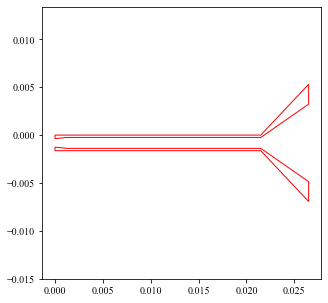

In [3]:
transition = bc.Transition(L_track=2.15*cm,
                           L_taper=0.5*cm,
                           L_tip=0.127*cm, 
                           w_gap=0.0245*cm, 
                           w_track=0.114*cm, 
                           w_tip=0.089*cm, 
                           w1=1.225*cm, 
                           w2=0.81*cm,
                           name='transition')
print(transition)
transition.plot()

### SIW parameters

PARAMETER                 VALUE                    
L_wg                      0.14700000000000002      
w_wg                      0.02                     
L_taper                   0.005                    
L_track                   0.0215                   
w_wall                    0.002445                 
pitch                     0.00115                  
even                      1                        
mode                      open                     
name                      siw                      
type                      scatter                  



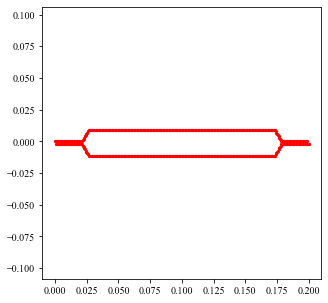

In [4]:
L_transition = transition.params['L_track'] + transition.params['L_taper']

siw = bc.SIW(L_wg=board.params['Lx_board'] - 2*L_transition,
             w_wg=board.params['w_wg'],
             L_taper=transition.params['L_taper'],
             L_track=transition.params['L_track'],
             w_wall=1.5*(transition.params['w_track']+2*transition.params['w_gap']),
             pitch=board.params['siw_via_pitch'],
             even=True,
             mode='open',
             name='siw')
print(siw)
siw.plot()

### Element parameters

PARAMETER                 VALUE                    
wx_cELC                   0.0037604                
wy_cELC                   0.0037604                
wx_gap                    0.00042840000000000006   
wy_gap                    0.00042840000000000006   
w_center                  0.0014280000000000002    
w_gap                     0.0005712                
w_arm1                    0.0008568000000000001    
w_arm2                    0.0008568000000000001    
cELC_varactor_gap         0.000225                 
w_cELC_varactor           0.00023                  
name                      cELC                     
type                      polygon                  
wx_tot                    0.0046172                
wy_tot                    0.0046172                



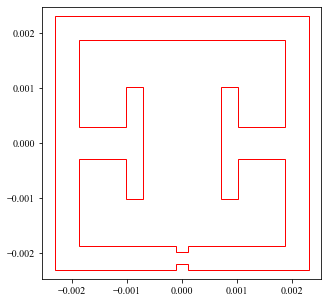

In [5]:
celc = bc.cELC(wx_cELC=0.37604*cm,
               wy_cELC=0.37604*cm,
               wx_gap=0.04284*cm,
               wy_gap=0.04284*cm,
               w_center=0.1428*cm,
               w_gap=0.05712*cm,
               w_arm1=0.08568*cm,
               w_arm2=0.08568*cm,
               cELC_varactor_gap=min(0.04284*cm, 0.0225*cm),
               w_cELC_varactor=0.023*cm)
print(celc)
celc.plot()

### Varactor params

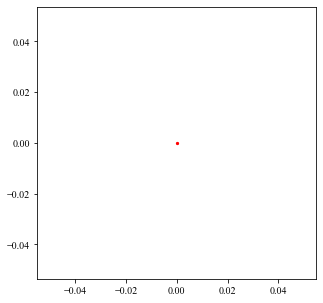

In [6]:
varactor = bc.Component(name='varactor')
varactor.params['type'] = 'scatter'
varactor.plot()

### Place items

In [7]:
### transition
delta_y = (board.params['waveguide_spacing']+siw.params['w_wg']+transition.params['w_track'])/2+transition.params['w_gap']
transition.move(x=0, y=board.params['Ly_board']/2 + delta_y).add().reset()
transition.reflect_y().move(x=board.params['Lx_board'], y=board.params['Ly_board']/2 + delta_y).add().reset()
delta_y = -(board.params['waveguide_spacing']+siw.params['w_wg'])/2 + transition.params['w_track']/2 + transition.params['w_gap']
transition.move(x=0, y=board.params['Ly_board']/2 + delta_y).add().reset()
transition.reflect_y().move(x=board.params['Lx_board'], y=board.params['Ly_board']/2 + delta_y).add().reset()
board.add(transition)

### siws
delta_y = (board.params['waveguide_spacing']+siw.params['w_wg']+siw.params['w_wall'])/2
siw.move(x=0, y=board.params['Ly_board']/2 + delta_y).add().reset()
delta_y = (-board.params['waveguide_spacing']-siw.params['w_wg']+siw.params['w_wall'])/2
siw.move(x=0, y=board.params['Ly_board']/2 + delta_y).add().reset()
board.add(siw)

### elements
board.params['n_elements_x'] = int((siw.params['L_wg'] - 2*board.params['element_x_offset'])/board.params['elements_delta_x'])

positions_x = np.arange(int(board.params['n_elements_x'])+1) * board.params['elements_delta_x']
positions_x = positions_x[:int(np.floor(positions_x.size/2)*2)]
positions_y = np.ravel(
                np.stack(
                    (board.params['elements_delta_y']/2*np.ones(int(positions_x.size/2)),
                    -board.params['elements_delta_y']/2*np.ones(int(positions_x.size/2))),
                    axis=1))
board.element_positions = np.append(np.array([positions_x + L_transition + board.params['element_x_offset'], 
                                                        positions_y + board.params['Ly_board']/2 + board.params['waveguide_spacing']/2 + siw.params['w_wg']/2]),
                                              np.array([positions_x + L_transition + board.params['element_x_offset'], 
                                                        positions_y + board.params['Ly_board']/2 - board.params['waveguide_spacing']/2 - siw.params['w_wg']/2]),
                                              axis=1).transpose()
for i in range(board.element_positions.shape[0]):
    celc.rotate(90).move(x=board.element_positions[i,0], y=board.element_positions[i,1]).add().reset()
board.add(celc)

### varactors
for i in range(board.element_positions.shape[0]):
    varactor.move(x=board.element_positions[i,0]+celc.params['wy_cELC']/2+celc.params['wy_gap']/2, y=board.element_positions[i,1]).add().reset()
board.add(varactor)

%matplotlib qt
print(board)
board.plot()

PARAMETER                 VALUE                    
Lx_board                  0.2                      
Ly_board                  0.07                     
eps_r                     3.38                     
f_design                  10000000000.0            
lambda_design             0.03                     
elements_delta_x          0.01                     
elements_delta_y          0.01                     
element_x_offset          0.003                    
w_wg                      0.02                     
waveguide_spacing         0.0025                   
f_c                       4076640000.007458        
n_g                       1.6787727699987698       
grating_threshold         0.011199158187655376     
via_diameter              0.0005                   
siw_via_pitch             0.00115                  
n_elements_x              14                       

COMPONENTS               
transition; siw; cELC; varactor; 



### Export design data

In [8]:
board.export_items('./Design Data')

### Save board object

In [9]:
import pickle

filename = './Design Data/board_test.pkl'

with open(filename, 'wb') as f:
    pickle.dump(board, f, protocol=2)